# Desafio Manutenção Preditiva

Por: Gustavo Perbone

Na célula abaixo estarão concentrados todos os imports necessários para o projeto. 

In [11]:
# imports

# data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# preparation for creatig the models
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# improving model parameters
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

#models used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#metrics
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve, roc_curve

import warnings
warnings.filterwarnings('ignore')

Como primeiro passo, vamos importar os dados de treino e explorá-los.

In [12]:
df_falhas = pd.read_csv('data/desafio_manutencao_preditiva_treino.csv')
display(df_falhas.head())
print(f'A tabela tem {df_falhas.shape[1]} colunas e {df_falhas.shape[0]} registros.')

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


A tabela tem 9 colunas e 6667 registros.


Dos dados fornecidos previamente nas instruções, sabemos que as seguintes colunas estão presentes no dataset:
- **udi**: é o identificador único de cada registro, indo de 1 a 10000;
- **product id**: consiste na letra L, M, H e umnúmero serial específico da variante;
- **type**: é o primeiro caracter do *product_id*, significando a qualidade da variante do produto: L(50% dos produtos), M(30% dos produtos) ou H(20%);
- **air temperature [K]**: gerada utilizando o método de passeio aleatório e posteriormente normalizada com um desvio padrão de 2 K em torno de 300 K;
- **process temperature [K]**: gerada utilizando o método de passeio aleatório e posteriormente normalizada com um desvio padrão de 1 K, adicionada a temperatura do ar mais 10 K;
- **rotational speed [rpm]**: calculada em torno de 300 K;de uma potência de 2860 W, sobreposta com um ruído de distribuição normal;
- **torque [Nm]**: os valores de torque se referem a uma distribuição normal em torno de 40 Nm com DP= 10 Nm e sem valores negativos;
- **tool wear [min]**: A qualidade das variantes H/M/L adivionam 5/3/2 minutos de desgaste à ferramenta utilizada no processo. 
- **failure type**: representa se houve falha no processo. Pode ser *No Failure* (sem falha), *tool wear failure (TWF)*, *heat dissipation failure (HDF)*, *power failure (PWF)*, *overstrain failure (OSF)* ou *random failures (RNF)*.

As instruções do problema ainda indicam que não é transparente para o modelo de ML qual foi o tipo da falha, e que se qualquer um deles ocorre, apenas é indicado isto. Vamos construir esta nova coluna (que será nosso target) no  dataset:

In [13]:
# Criando coluna TARGET indicando se houve falha (1) ou não (0)
df_falhas['target'] = df_falhas.apply(lambda x: 0 if x.failure_type == "No Failure" else 1, axis=1)

In [14]:
#Vamos conferir se a atribuição acima está correta
df_falhas.tail(20)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,target
6647,9974,L57153,L,298.5,308.2,1444,40.5,170,No Failure,0
6648,9975,L57154,L,298.6,308.2,1361,68.2,172,Power Failure,1
6649,9978,L57157,L,298.6,308.3,1422,40.4,179,No Failure,0
6650,9979,H39392,H,298.6,308.3,1377,52.1,181,No Failure,0
6651,9980,L57159,L,298.5,308.3,1334,49.8,186,No Failure,0
6652,9981,L57160,L,298.6,308.4,1559,36.6,188,No Failure,0
6653,9982,L57161,L,298.7,308.5,1353,47.0,190,No Failure,0
6654,9983,M24842,M,298.7,308.4,1507,45.7,192,No Failure,0
6655,9985,H39398,H,298.7,308.4,1432,42.8,197,No Failure,0
6656,9987,M24846,M,298.8,308.6,1507,42.3,207,No Failure,0


In [15]:
# Tudo certo, então podemos deletar a coluna failure_type
df_falhas.drop(["failure_type"], axis = 1, inplace=True)

In [16]:
# Verificando se há valores vazios e os tipos
df_falhas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   target                 6667 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 468.9+ KB


In [17]:
# Verificando a quantidade de valores únicos por coluna
df_falhas.nunique()

udi                      6667
product_id               6667
type                        3
air_temperature_k          93
process_temperature_k      82
rotational_speed_rpm      840
torque_nm                 547
tool_wear_min             243
target                      2
dtype: int64

Podemos concluir que não há valores vazios no dataset de treino. Também é possível concluir que as colunas *udi* e *product_id* são exclusivas de cada linha, então elas não serão úteis para o modelo. Podemos removê-las:

In [18]:
df_falhas.drop(["udi", "product_id"], axis = 1, inplace=True)
df_falhas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   6667 non-null   object 
 1   air_temperature_k      6667 non-null   float64
 2   process_temperature_k  6667 non-null   float64
 3   rotational_speed_rpm   6667 non-null   int64  
 4   torque_nm              6667 non-null   float64
 5   tool_wear_min          6667 non-null   int64  
 6   target                 6667 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 364.7+ KB


Por fim, temos 1 feature do tipo object e 5 features do tipo numéricas, sendo 3 float e 2 inteiras. O target é um inteiro.
<br/>
Abaixo faremos a exploração destes dados.

## Análise Exploratória dos Dados

Agora podemos explorar os dados que temos disponíveis para criação do modelo, para entender suas distribuições, se há outliers, e se há alguma vairável que precisa ser transformada.

In [9]:
df_falhas.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095,0.034798
std,1.994710,1.488101,177.182908,9.950804,63.359915,0.183282
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000,0.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000,1.000000


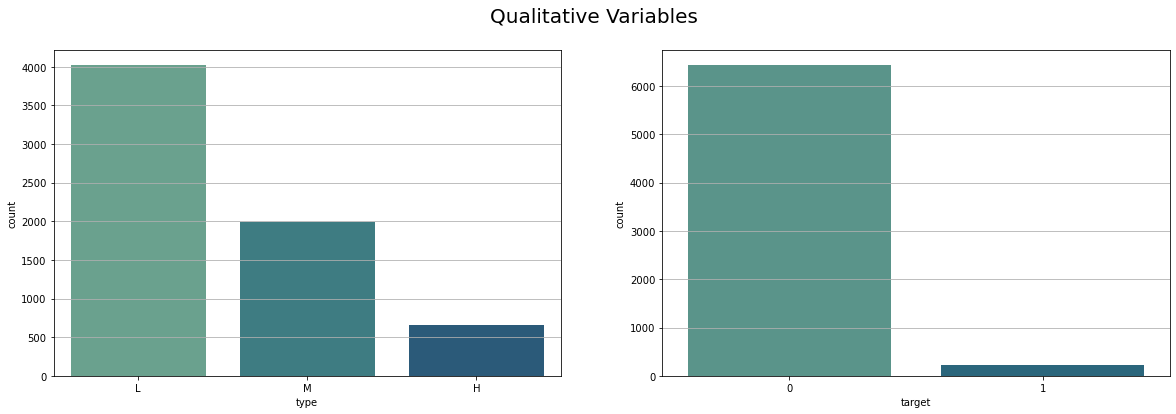

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
 
sns.countplot(data=df_falhas, x='type', palette = 'crest', order=['L', 'M', 'H'], ax=ax[0])
ax[0].grid(axis='y')

sns.countplot(data=df_falhas, x='target', palette = 'crest', ax=ax[1])
ax[1].grid(axis='y')



plt.suptitle('Qualitative Variables', fontsize=20)
plt.show()

In [28]:
print("Tipo de falhas")
print(df_falhas.type.value_counts(normalize=True))
print()
print("Target")
print(df_falhas.target.value_counts(normalize=True))

Tipo de falhas
L    0.603270
M    0.298035
H    0.098695
Name: type, dtype: float64

Target
0    0.965202
1    0.034798
Name: target, dtype: float64


Iniciando pelas **variáveis qualitativas**, temos que:
- **type**: a maioria dos produtos é da variante L (60%), seguido por M (30%) e H (10%).
- **target**: apenas 3% dos dados são falhas. Isso precisará ser balanceado antes do treinamento dos modelos.

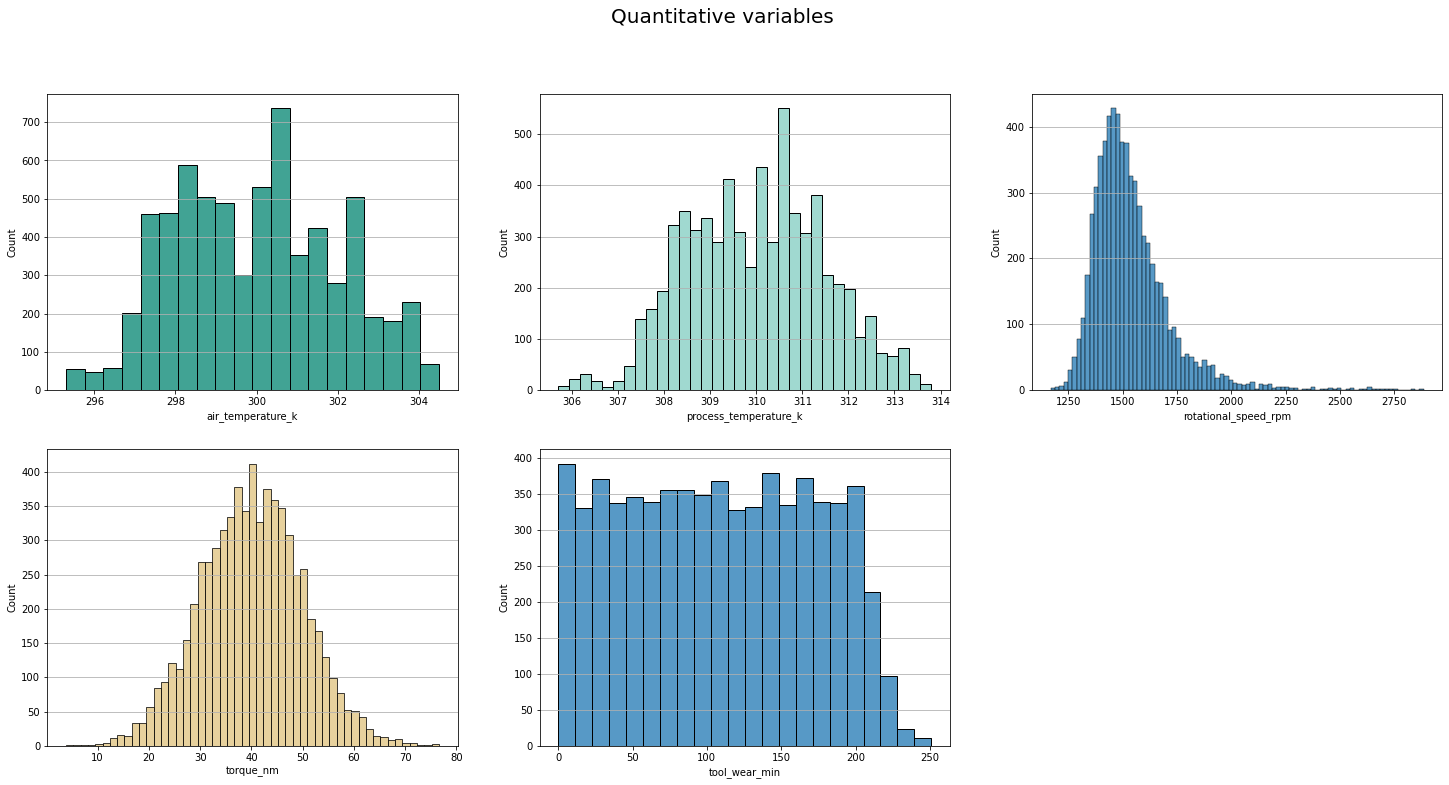

In [43]:
fig, ax = plt.subplots(2,3, figsize=(25,12))

sns.histplot(data=df_falhas, x='air_temperature_k', color='#018571', bins=20, ax=ax[0,0])
ax[0,0].grid(axis='y')

sns.histplot(data=df_falhas, x='process_temperature_k', color='#80cdc1', ax=ax[0,1])
ax[0,1].grid(axis='y')

sns.histplot(data=df_falhas, x='rotational_speed_rpm', palette = 'BrBG', ax=ax[0,2])
ax[0,2].grid(axis='y')

sns.histplot(data=df_falhas, x='torque_nm', color='#dfc27d', ax=ax[1,0])
ax[1,0].grid(axis='y')

sns.histplot(data=df_falhas, x='tool_wear_min', palette = 'BrBG', ax=ax[1,1])
ax[1,1].grid(axis='y')

fig.delaxes(ax[1,2])

plt.suptitle('Quantitative variables', fontsize=20)
plt.show()

Em relação às variáveis **quantitativas**, temos que:
- **air_temperature_K**: segue uma distribuição que aparenta ser normal, mas não é perfeita. A média é 300K com DP de 2 K, sendo mínimo valor 295.3 K e o máximo 304.5 K;
- **process_temperature_k**: também segue uma distribuição próxima da normal, mas não é perfeita. A média é 310 K com DP de 1.49 K, sendo mínimo valor 305.7 K e o máximo 313.8 K;
- **rotational_speed_rpm**: tem uma distribuição assimétrica, com distribuição concentrada na esquerda e cauda longa à direita;
- **torque_nm**: tem uma distribuição normal, com média 40.05 Nm e DP 9.95 Nm;
- **tool_wear_min**: tem uma distribuição que se assemelha à uniforme, entre os valores mínimo e máximo (0 min e 251 min).

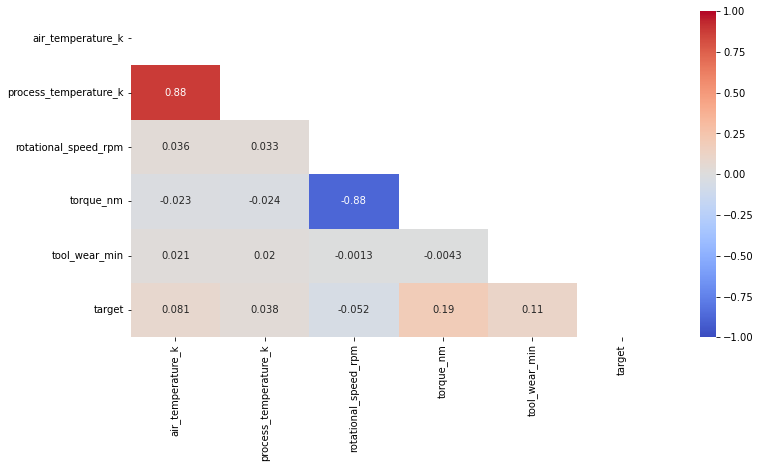

In [46]:

plt.figure(figsize=(12, 6))
mask=np.triu(np.ones_like(df_falhas.corr()))
sns.heatmap(df_falhas.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, mask=mask);

<AxesSubplot:>

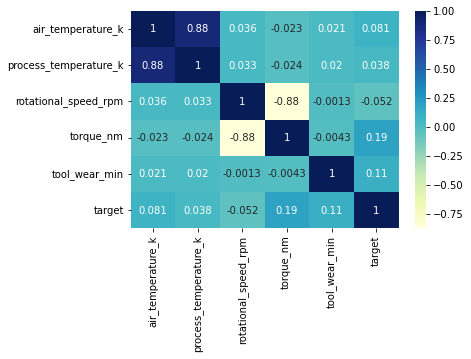

In [47]:
sns.heatmap(df_falhas.corr(), annot=True, cmap='YlGnBu')


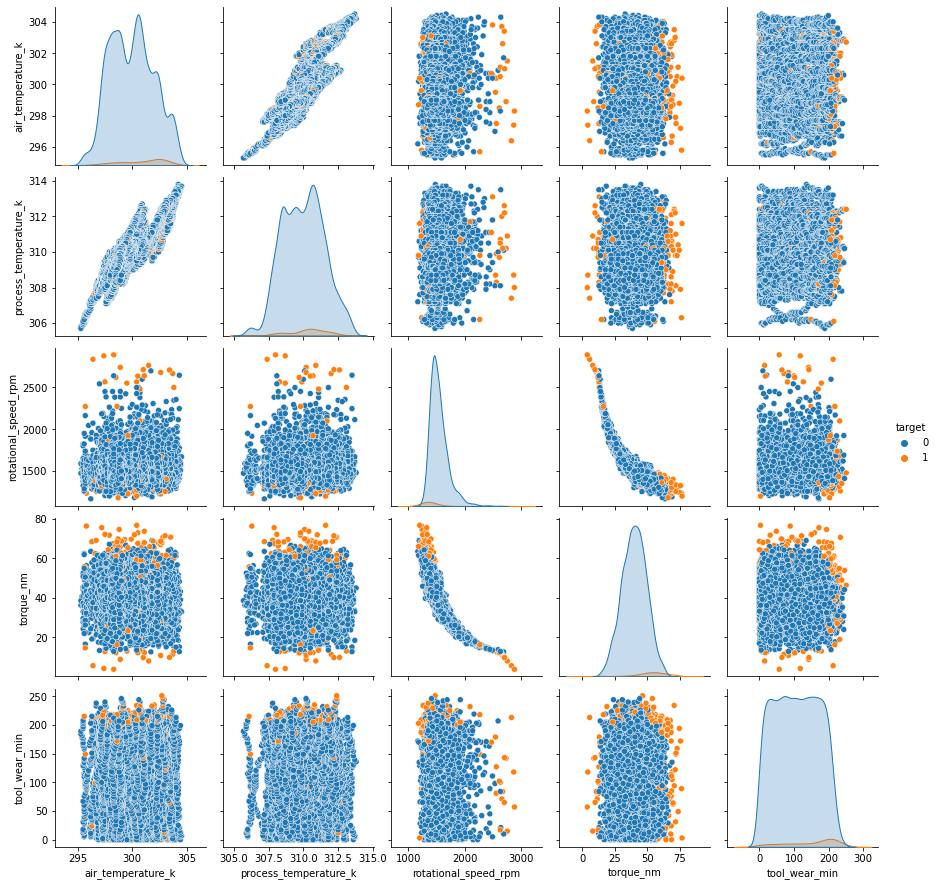

In [41]:
sns.pairplot(df_falhas, hue='target')